In [9]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pennylane as qml
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('task-3-dataset.csv', header=0, quotechar='"', skipinitialspace=True, encoding='utf-8')

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ReviewDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        review = self.dataframe.iloc[idx, 0]  # Extract the review text
        label = 1 if self.dataframe.iloc[idx, 1] == '+' else 0  # Extract the label
        encoding = self.tokenizer(review, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Define the quantum node
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs,weights): # weights_1_layer, weights_2_layer):
    # print(inputs)
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    # ZZFeatureMap(inputs=inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights=weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

num_layers = 8
weight_shapes = {
    "weights": (num_layers,n_qubits,3)
}

# Initialize the parameters
np.random.seed(42)
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# class QuantumNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.input_fc = nn.Linear(in_features=max_token_length, out_features=30)
#         self.fc1 = nn.Linear(in_features=30, out_features=n_qubits)
#         self.qlayer = qlayer
#         self.output_fc = nn.Linear(in_features=n_qubits, out_features=1)
#         self.sigmoid = nn.Sigmoid()
# 
#     def forward(self, input_ids, labels=None):
#         x = self.input_fc(input_ids)
#         x = torch.relu(x)
#         x = self.fc1(x)
#         x = self.qlayer(x)
#         x = self.output_fc(x)
#         x = self.sigmoid(x)
#         return x



# Tokenize the texts
max_token_length = 100

dataset = ReviewDataset(dataframe=df, max_len=max_token_length)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

clayer1 = nn.Linear(in_features=max_token_length, out_features=30)
sigm1 = nn.Sigmoid()
clayer2 = nn.Linear(in_features=30, out_features=n_qubits)
outclayer = nn.Linear(in_features=n_qubits, out_features=1)
sigmoid = nn.Sigmoid()
model = nn.Sequential(clayer1,sigm1,clayer2,qlayer,outclayer,sigmoid)

# model = QuantumNetwork()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

/home/VF/anaconda3/envs/hybridquantum/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
for param in model.parameters():
    print(param.shape)

torch.Size([30, 100])
torch.Size([30])
torch.Size([4, 30])
torch.Size([4])
torch.Size([8, 4, 3])
torch.Size([1, 4])
torch.Size([1])


In [17]:
# optimizer = optim.Adam(model.parameters(), lr=2e-3)
criterion = nn.BCELoss()
epochs = 20

# Training loop
losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in dataloader:

        input_ids = batch['input_ids'].to(torch.float32)
        input_ids = (input_ids - input_ids.mean()) / (input_ids.std())
        attention_mask = batch['attention_mask'].to(torch.float32)
        labels = batch['labels'].to(torch.float32).unsqueeze(-1)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        correct_predictions += ((outputs>0.5).to(int) == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_predictions
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 1/20, Loss: 0.7164, Accuracy: 0.6600
Epoch 2/20, Loss: 0.6135, Accuracy: 0.7400
Epoch 3/20, Loss: 0.5503, Accuracy: 0.7600
Epoch 4/20, Loss: 0.5166, Accuracy: 0.7800
Epoch 5/20, Loss: 0.4895, Accuracy: 0.7800
Epoch 6/20, Loss: 0.4593, Accuracy: 0.8000
Epoch 7/20, Loss: 0.4367, Accuracy: 0.7800
Epoch 8/20, Loss: 0.4083, Accuracy: 0.8800
Epoch 9/20, Loss: 0.3795, Accuracy: 0.8800
Epoch 10/20, Loss: 0.3514, Accuracy: 0.8800
Epoch 11/20, Loss: 0.3244, Accuracy: 0.9000
Epoch 12/20, Loss: 0.2989, Accuracy: 0.9200
Epoch 13/20, Loss: 0.2800, Accuracy: 0.9200
Epoch 14/20, Loss: 0.2600, Accuracy: 0.9400
Epoch 15/20, Loss: 0.2404, Accuracy: 0.9600
Epoch 16/20, Loss: 0.2272, Accuracy: 0.9600
Epoch 17/20, Loss: 0.2106, Accuracy: 0.9600
Epoch 18/20, Loss: 0.1919, Accuracy: 0.9600
Epoch 19/20, Loss: 0.1769, Accuracy: 0.9600
Epoch 20/20, Loss: 0.1652, Accuracy: 0.9800


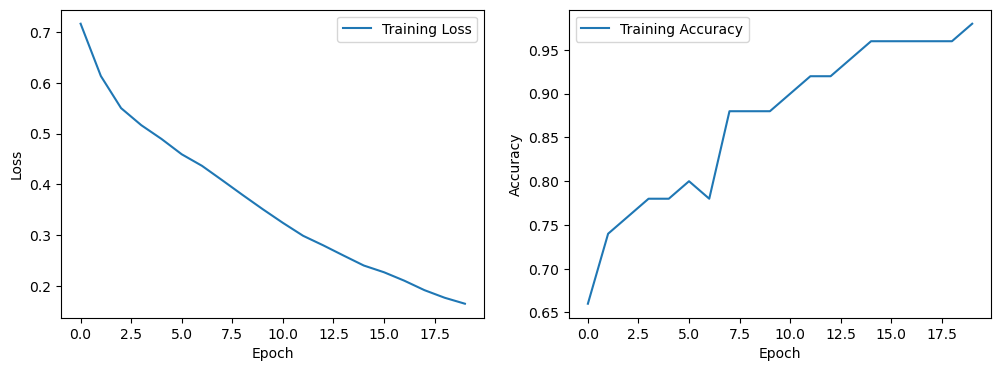

In [18]:
# Plot metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
df = pd.read_csv('test50.csv', header=0, quotechar='"', skipinitialspace=True, encoding='utf-8')
dataset = ReviewDataset(dataframe=df, max_len=max_token_length)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

for batch in dataloader:
    
    input_ids = batch['input_ids'].to(torch.float32)
    input_ids = (input_ids - input_ids.mean()) / (input_ids.std())
    attention_mask = batch['attention_mask'].to(torch.float32)
    labels = batch['labels'].to(torch.float32).unsqueeze(-1)
    
    optimizer.zero_grad()
    outputs = model(input_ids)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    correct_predictions += ((outputs>0.5).to(int) == labels).sum().item()
    total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_predictions
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 20/20, Loss: 0.3162, Accuracy: 0.9800
